# 06 - Neural Network (TensorFlow/Keras)

Goal: train a simple neural network within this notebook (no CLI training).

Key elements:
- Input normalization (using scaler from preprocessing)
- Dropout regularization
- Early stopping
- Training history plots


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

PROCESSED_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results')
METRICS_DIR = RESULTS_DIR / 'metrics'
FIGURES_DIR = RESULTS_DIR / 'figures'
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("LOADING DATA - USING IMBALANCED DATA WITH CLASS WEIGHTS")
print("="*70)

# Load ORIGINAL imbalanced scaled data (NOT SMOTE)
X_train_full = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
y_train_full = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()
X_test = pd.read_csv(PROCESSED_DIR / 'X_test_scaled.csv')
y_test = pd.read_csv(PROCESSED_DIR / 'y_test.csv').squeeze()

print(f"Training data: {X_train_full.shape}")
print(f"  Class 0: {sum(y_train_full==0):,} ({sum(y_train_full==0)/len(y_train_full)*100:.1f}%)")
print(f"  Class 1: {sum(y_train_full==1):,} ({sum(y_train_full==1)/len(y_train_full)*100:.1f}%)")

# Compute class weights to handle imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weight = {0: class_weights_array[0], 1: class_weights_array[1]}
print(f"\nComputed class weights: {class_weight}")
print(f"  Non-fraud weight: {class_weight[0]:.2f}")
print(f"  Fraud weight: {class_weight[1]:.2f}")

# Stratified split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f"\nAfter stratified split:")
print(f"Training: {X_train.shape}, Fraud: {sum(y_train==1):,}/{len(y_train):,} ({sum(y_train==1)/len(y_train)*100:.2f}%)")
print(f"Validation: {X_val.shape}, Fraud: {sum(y_val==1):,}/{len(y_val):,} ({sum(y_val==1)/len(y_val)*100:.2f}%)")
print(f"Test: {X_test.shape}, Fraud: {sum(y_test==1):,}/{len(y_test):,} ({sum(y_test==1)/len(y_test)*100:.2f}%)")

# Build neural network
inputs = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
model.summary()

# Setup callbacks
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
best_model_path = str(MODEL_DIR / 'best_nn_model.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        best_model_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=20,
        restore_best_weights=False,
        verbose=1
    )
]

print(f"\nTraining for up to 100 epochs with class weights...")
print(f"Best model will be saved to: {best_model_path}")
print("="*70)

# Train with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    class_weight=class_weight,  # Use computed class weights
    callbacks=callbacks,
    verbose=2
)

print("\n" + "="*70)
print("LOADING BEST MODEL")
print("="*70)

best_model = keras.models.load_model(best_model_path)
print(f"Loaded from: {best_model_path}")

best_epoch = np.argmax(history.history['val_auc']) + 1
best_val_auc = max(history.history['val_auc'])
print(f"Best epoch: {best_epoch} (val_auc: {best_val_auc:.4f})")

print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Get predictions
y_pred_probs = best_model.predict(X_test, verbose=0).flatten()

print(f"\nPrediction probability stats:")
print(f"  Min: {y_pred_probs.min():.6f}, Max: {y_pred_probs.max():.4f}")
print(f"  Mean: {y_pred_probs.mean():.6f}, Median: {np.median(y_pred_probs):.6f}")
print(f"  25th percentile: {np.percentile(y_pred_probs, 25):.6f}")
print(f"  75th percentile: {np.percentile(y_pred_probs, 75):.6f}")
print(f"  Predictions > 0.5: {(y_pred_probs > 0.5).sum():,} ({(y_pred_probs > 0.5).sum()/len(y_pred_probs)*100:.2f}%)")

# Find optimal threshold
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold (max Youden's J): {optimal_threshold:.6f}")

# Evaluate at optimal threshold
y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)
class_report_optimal = classification_report(y_test, y_pred_optimal, output_dict=True)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"\nTest Results (threshold={optimal_threshold:.6f}):")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  Precision (Fraud): {class_report_optimal['1']['precision']:.4f}")
print(f"  Recall (Fraud): {class_report_optimal['1']['recall']:.4f}")
print(f"  F1-Score (Fraud): {class_report_optimal['1']['f1-score']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN: {cm_optimal[0,0]:,}  |  FP: {cm_optimal[0,1]:,}")
print(f"  FN: {cm_optimal[1,0]:,}  |  TP: {cm_optimal[1,1]:,}")

# Also evaluate at 0.5 threshold
y_pred_50 = (y_pred_probs > 0.5).astype(int)
cm_50 = confusion_matrix(y_test, y_pred_50)
class_report_50 = classification_report(y_test, y_pred_50, output_dict=True)

print(f"\nResults at 0.5 threshold (for comparison):")
print(f"  Precision: {class_report_50['1']['precision']:.4f}")
print(f"  Recall: {class_report_50['1']['recall']:.4f}")
print(f"  F1-Score: {class_report_50['1']['f1-score']:.4f}")
print(f"  TN={cm_50[0,0]:,}, FP={cm_50[0,1]:,}, FN={cm_50[1,0]:,}, TP={cm_50[1,1]:,}")

# Save results
results = {
    'approach': 'Imbalanced data with class weights (NOT SMOTE)',
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'class_weights': {k: float(v) for k, v in class_weight.items()},
    'total_epochs': len(history.history['loss']),
    'best_epoch': int(best_epoch),
    'best_val_auc': float(best_val_auc),
    'optimal_threshold': float(optimal_threshold),
    'test_metrics': {
        'roc_auc': float(roc_auc),
        'precision': float(class_report_optimal['1']['precision']),
        'recall': float(class_report_optimal['1']['recall']),
        'f1_score': float(class_report_optimal['1']['f1-score']),
        'accuracy': float(class_report_optimal['accuracy'])
    },
    'classification_report': class_report_optimal,
    'confusion_matrix': cm_optimal.tolist()
}

with open(METRICS_DIR / '06_neural_network_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\nSaved to: {METRICS_DIR / '06_neural_network_results.json'}")
print("="*70)

results['test_metrics']

LOADING DATA - USING IMBALANCED DATA WITH CLASS WEIGHTS
Training data: (80000, 375)
  Class 0: 79,200 (99.0%)
  Class 1: 800 (1.0%)

Computed class weights: {0: np.float64(0.5050505050505051), 1: np.float64(50.0)}
  Non-fraud weight: 0.51
  Fraud weight: 50.00

After stratified split:
Training: (64000, 375), Fraud: 640/64,000 (1.00%)
Validation: (16000, 375), Fraud: 160/16,000 (1.00%)
Test: (20000, 375), Fraud: 200/20,000 (1.00%)

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 375)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,265 (231.50 KB)

 Trainable params: 58,881 (230.00 KB)

 Non-trainable params: 384 (1.50 KB)


Training for up to 100 epochs with class weights...
Best model will be saved to: ..\models\best_nn_model.keras
Epoch 1/100

Epoch 1: val_auc improved from None to 0.48457, saving model to ..\models\best_nn_model.keras
125/125 - 4s - 35ms/step - accuracy: 0.4688 - auc: 0.5127 - loss: 1.0773 - precision: 0.0104 - recall: 0.5531 - val_accuracy: 0.1226 - val_auc: 0.4846 - val_loss: 1.0035 - val_precision: 0.0099 - val_recall: 0.8750
Epoch 2/100

Epoch 2: val_auc did not improve from 0.48457
125/125 - 1s - 6ms/step - accuracy: 0.4880 - auc: 0.5106 - loss: 0.9891 - precision: 0.0105 - recall: 0.5359 - val_accuracy: 0.3771 - val_auc: 0.4736 - val_loss: 0.9407 - val_precision: 0.0097 - val_recall: 0.6062
Epoch 3/100

Epoch 3: val_auc did not improve from 0.48457
125/125 - 1s - 7ms/step - accuracy: 0.5410 - auc: 0.5870 - loss: 0.9152 - precision: 0.0128 - recall: 0.5906 - val_accuracy: 0.5410 - val_auc: 0.4743 - val_loss: 0.8979 - val_precision: 0.0090 - val_recall: 0.4125
Epoch 4/100

Epoch 4

{'roc_auc': 0.5292714646464647,
 'precision': 0.01159334126040428,
 'recall': 0.585,
 'f1_score': 0.022736105713175282,
 'accuracy': 0.4971}

Saved: ..\results\figures\06_neural_network_training_history.png


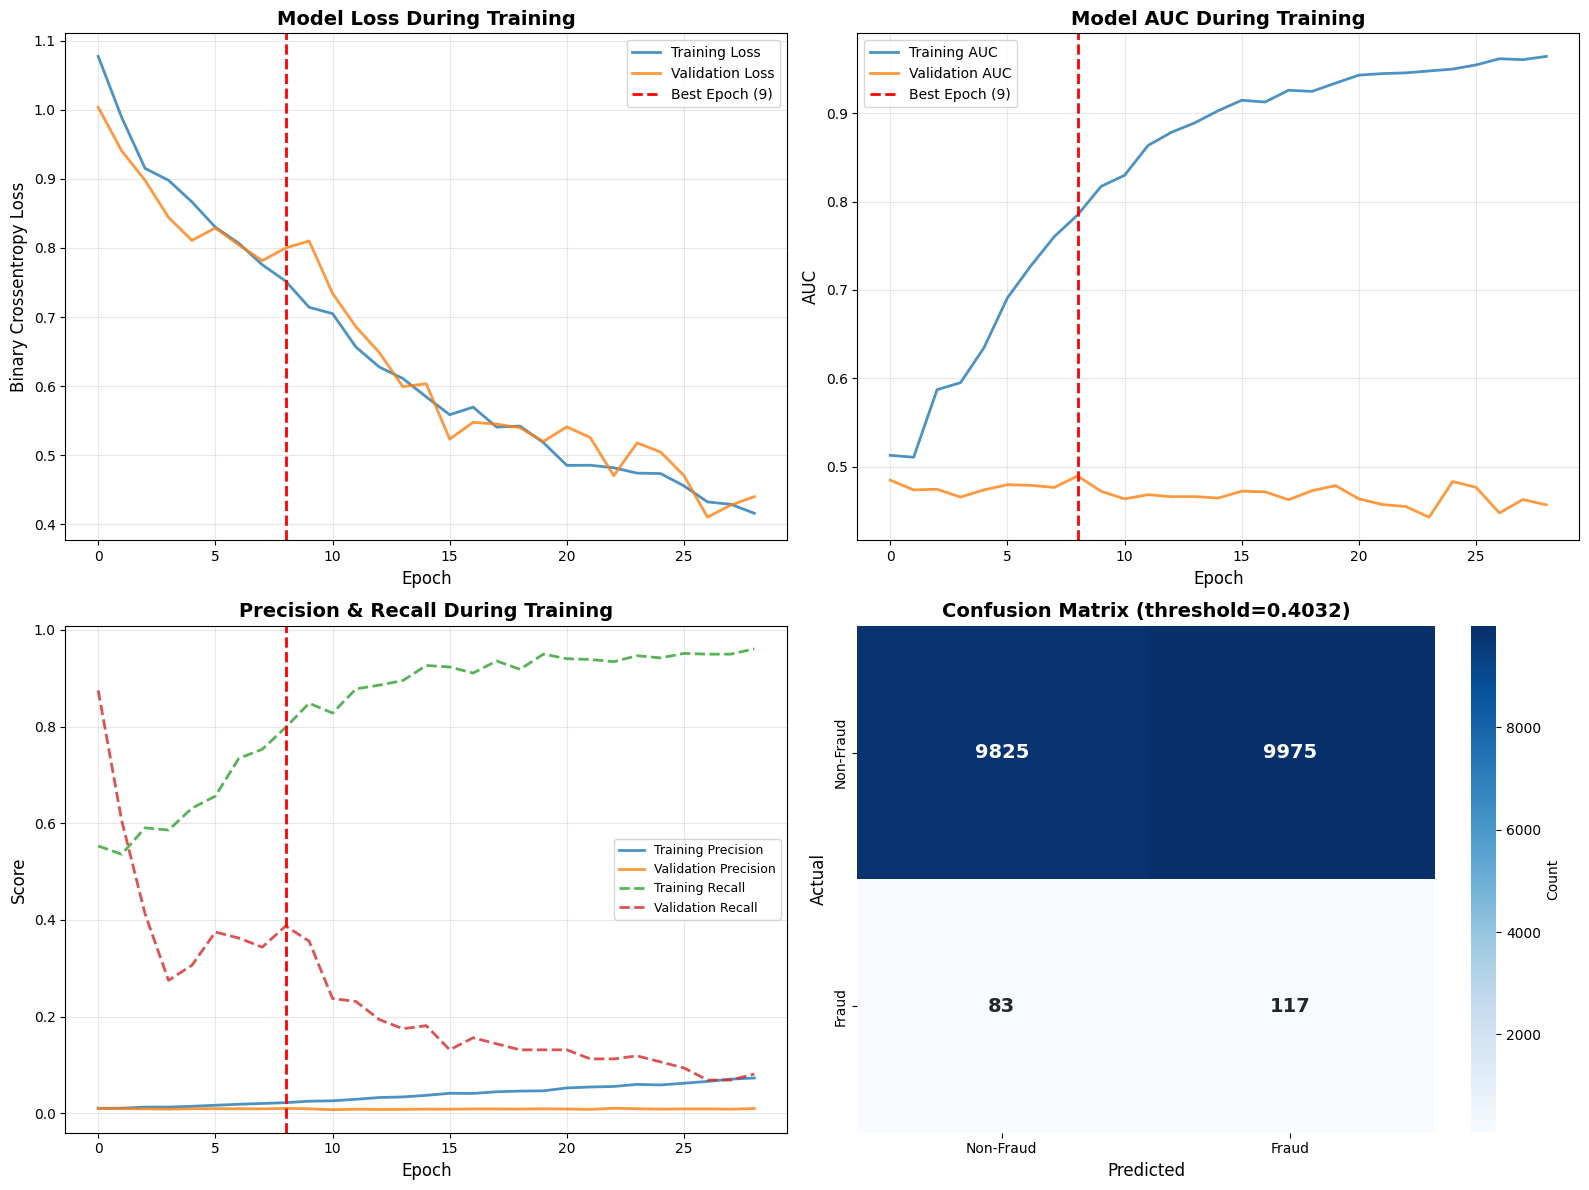

TRAINING SUMMARY
Total epochs: 29
Best epoch: 9 (val_auc: 0.4893)

Test Performance:
  ROC-AUC: 0.5293
  Threshold: 0.403230
  Precision: 0.0116
  Recall: 0.5850
  F1-Score: 0.0227


In [5]:
# Plot training history
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
axes[0, 0].axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
axes[0, 0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Binary Crossentropy Loss', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: AUC
axes[0, 1].plot(history.history['auc'], label='Training AUC', linewidth=2, alpha=0.8)
axes[0, 1].plot(history.history['val_auc'], label='Validation AUC', linewidth=2, alpha=0.8)
axes[0, 1].axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})', linewidth=2)
axes[0, 1].set_title('Model AUC During Training', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('AUC', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision & Recall
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, alpha=0.8)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, alpha=0.8)
axes[1, 0].plot(history.history['recall'], label='Training Recall', linewidth=2, alpha=0.8, linestyle='--')
axes[1, 0].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, alpha=0.8, linestyle='--')
axes[1, 0].axvline(x=best_epoch-1, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Precision & Recall During Training', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'},
            annot_kws={'fontsize': 14, 'weight': 'bold'})
axes[1, 1].set_title(f'Confusion Matrix (threshold={optimal_threshold:.4f})', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
fig.savefig(FIGURES_DIR / '06_neural_network_training_history.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '06_neural_network_training_history.png'}")
plt.show()

print("=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"Total epochs: {len(history.history['loss'])}")
print(f"Best epoch: {best_epoch} (val_auc: {best_val_auc:.4f})")
print(f"\nTest Performance:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  Threshold: {optimal_threshold:.6f}")
print(f"  Precision: {class_report_optimal['1']['precision']:.4f}")
print(f"  Recall: {class_report_optimal['1']['recall']:.4f}")
print(f"  F1-Score: {class_report_optimal['1']['f1-score']:.4f}")
print("=" * 70)


Save the trained model to `models/saved_models` if performance is acceptable.